# Lab 1: Building your Agent 

The agent is comprised of a router using OpenAI function calling, and a set of three tools: a database lookup tool, a data analysis tool, and a code generator to create graphs.

<img src="images/agent.png" width="500"/>


The agent can lookup information from a local file, perform analysis on that information, and graph results. The example local file is a log of transactions at a local store. The agent can help the store owners understand trends and anomalies in their sales data.

## Importing necessary libraries 

In [4]:
from openai import AzureOpenAI
import pandas as pd
import json
import duckdb
from pydantic import BaseModel, Field

from helper import get_azure_openai_configurations

## Initializing the OpenAI client

In [5]:
# initialize the OpenAI client
openai_api_config = get_azure_openai_configurations()

client = AzureOpenAI(
    api_version=openai_api_config.api_version,
    azure_endpoint=openai_api_config.azure_endpoint,
    api_key=openai_api_config.api_key,
)

MODEL = openai_api_config.deployment

## Defining the tools

Let's start by creating the three tools the agent will be able to use.

### Tool 1: Database Lookup

This first tool reads from a local parquet file that contains the transaction data. 

In [6]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'data/Store_Sales_Price_Elasticity_Promotions_Data.parquet'

This database lookup tool works using three steps. 

<img src="images/tool1.png" width="500"/>

1. First, it creates the SQL table from a local file, if not already done.
2. Second, it translates the original prompt into an sql query (using an LLM call).
3. Finally, it runs that query against the database.

In [7]:
# prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """
Generate a DuckDB SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}

IMPORTANT DATA TYPE INFORMATION:
- The 'date' column is stored as VARCHAR (string) in format 'YYYY-MM-DD', NOT as a DATE type
- Do NOT use YEAR(), MONTH(), or other date functions directly on the 'date' column
- For year filtering, use: WHERE date BETWEEN 'YYYY-01-01' AND 'YYYY-12-31'
- For month filtering, use: WHERE date BETWEEN 'YYYY-MM-01' AND 'YYYY-MM-31'
- Or use string comparison: WHERE date >= '2021-01-01' AND date <= '2021-12-31'
- If you need to extract year/month, use: CAST(date AS DATE) first, then apply date functions

Example correct queries:
- Get 2021 data: WHERE date BETWEEN '2021-01-01' AND '2021-12-31'
- Get November 2021: WHERE date BETWEEN '2021-11-01' AND '2021-11-30'
- Extract year: strftime('%Y', CAST(date AS DATE)) or YEAR(CAST(date AS DATE))
"""

In [8]:
# code for step 2 of tool 1
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, 
                                                    columns=columns, 
                                                    table_name=table_name)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    return response.choices[0].message.content

In [9]:
# code for tool 1
def lookup_sales_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:

        # define the table name
        table_name = "sales"
        
        # step 1: read the parquet file into a DuckDB table
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the SQL code
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        # clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        
        # step 3: execute the SQL query
        result = duckdb.sql(sql_query).df()
        
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

Great! Now let's test the first tool and make sure it worked correctly.

In [10]:
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
print(example_data)

   store_id        date product_sku  quantity  unit_price  sales_amount  promotion  base_price  day_of_week  month
0      1320  2021-11-01    SKU_0048        14       83.62       1170.67          0       83.62            0     11
1      1320  2021-11-01    SKU_0010        17       64.35       1094.01          0       64.35            0     11
2      1320  2021-11-01    SKU_0013        20        8.96        179.22          1       12.62            0     11
3      1320  2021-11-01    SKU_0040        28       36.09       1010.52          1       41.02            0     11
4      1320  2021-11-01    SKU_0012        17       86.01       1462.10          0       86.01            0     11
5      1320  2021-11-01    SKU_0008        22       37.51        825.30          1       45.21            0     11
6      1320  2021-11-01    SKU_0036        38       78.93       2999.22          1       88.84            0     11
7      1320  2021-11-01    SKU_0018        14       14.64        205.02         

### Tool 2: Data Analysis

The second tool can analyze the returned data and display conclusions to users.

In [11]:
# Construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [12]:
# code for tool 2
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

This tool is relatively simple, but let's still test it out to be sure things are working correctly.

In [13]:
print(analyze_sales_data(prompt="what trends do you see in this data", 
                         data=example_data))

Let's analyze the provided sales data for store_id 1320 on the date 2021-11-01.

### Data Summary
- **Products (SKU)**: 9 different SKUs sold.
- **Promotion**: Some products were sold under promotion (promotion=1), others were not (promotion=0).
- **Quantities Sold**: Range from 11 to 38 units.
- **Unit Prices and Base Prices**: Unit prices are either equal to or less than base prices, indicating discount pricing during promotions.
- **Sales Amount**: Calculated as `quantity * unit_price`.

### Observed Trends

1. **Promotion Impact on Pricing**:
   - For SKUs where `promotion=1`, the `unit_price` is lower than the `base_price`, indicating a discount during promotion.
     - Example: SKU_0013 (promotion=1), base_price=12.62, unit_price=8.96.
   - For SKUs without promotion (promotion=0), `unit_price` equals `base_price`.
     - Example: SKU_0010 (promotion=0), unit_price=64.35 equals base_price 64.35.

2. **Effect of Promotion on Quantity Sold**:
   - Products with promotion generally 

### Tool 3: Data Visualization

The third tool generates python code to create the requested graphs from the returned data of the first tool. It consists of two steps:
<img src="images/tool3.png" width="500"/>
1. First, it creates the chart configuration: chart type, title, data, lables for x-axis and y-axis (using an LLM call).
2. Second, it generates the python code based on the chart configuration of the first step (using an LLM call).

In [14]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [15]:
# class defining the response format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [16]:
# code for step 1 of tool 3
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration
    
    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Dictionary containing line chart configuration
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data,
                                                         visualization_goal=visualization_goal)
    
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
        response_format=VisualizationConfig,
    )
    
    try:
        # Extract axis and title info from response
        content = response.choices[0].message.content
        
        # Return structured chart config
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

In [17]:
# prompt template for step 2 of tool 3
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

In [18]:
# code for step 2 of tool 3
def create_chart(config: dict) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()
    
    return code

In [19]:
# code for tool 3
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

Great, now let's try the third tool out:

In [20]:
code = generate_visualization(example_data, 
                              "A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.")
print(code)

import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

data = '''   store_id        date product_sku  quantity  unit_price  sales_amount  promotion  base_price  day_of_week  month
0      1320  2021-11-01    SKU_0048        14       83.62       1170.67          0       83.62            0     11
1      1320  2021-11-01    SKU_0010        17       64.35       1094.01          0       64.35            0     11
2      1320  2021-11-01    SKU_0013        20        8.96        179.22          1       12.62            0     11
3      1320  2021-11-01    SKU_0040        28       36.09       1010.52          1       41.02            0     11
4      1320  2021-11-01    SKU_0012        17       86.01       1462.10          0       86.01            0     11
5      1320  2021-11-01    SKU_0008        22       37.51        825.30          1       45.21            0     11
6      1320  2021-11-01    SKU_0036        38       78.93       2999.22          1       88.84            0 

<string>:16: SyntaxWarning: invalid escape sequence '\s'


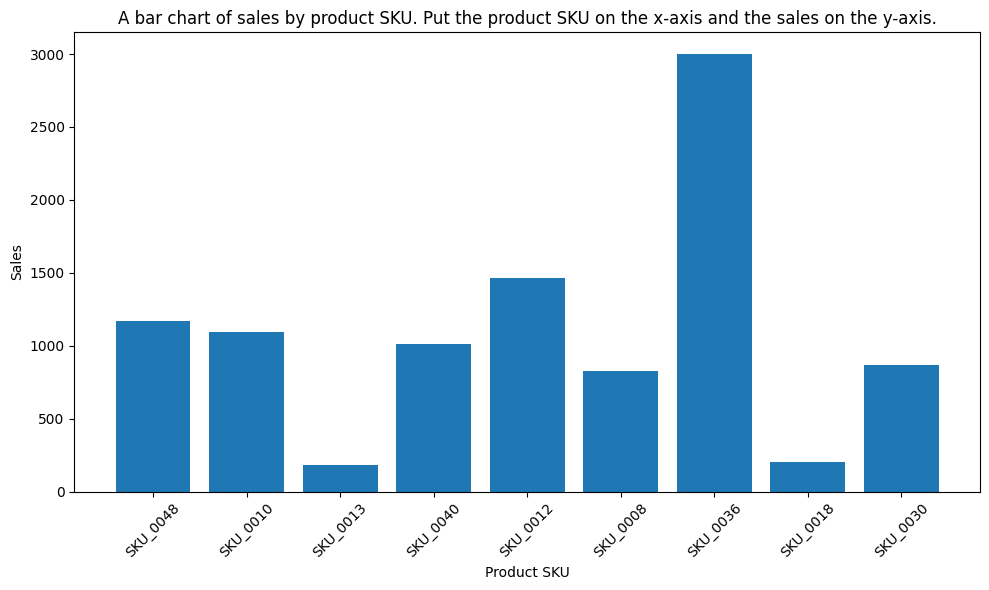

In [21]:
exec(code)

## Defining the Router

Now that all of the tools are defined, you can create the router. The router will take the original user input, and is responsible for calling any tools. After each tool call is completed, the agent will return to router to determine whether another tool should be called.

### Tool Schema

Let's define the tools in a way that can be understood by our OpenAI model. OpenAI understands a specific JSON format:

In [22]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_sales_data",
            "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data", 
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object", 
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data, 
    "generate_visualization": generate_visualization
}

### Router Logic

The router is composed of a main loop method, and a method to handle the tool calls that you get back from the model.

The following two cells define the function `handle_tool_calls` and the variable `SYSTEM_PROMPT`, which will be used by the function `run_agent` defining the router logic.

In [23]:
# code for executing the tools returned in the model's response
def handle_tool_calls(tool_calls, messages):
    
    for tool_call in tool_calls:   
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.id})
        
    return messages

In [24]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

In [25]:
def run_agent(messages):
    print("Running agent with messages:", messages)

    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
        
    # Check and add system prompt if needed
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
            messages.append(system_prompt)

    while True:
        print("Making router call to OpenAI")
        response = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            tools=tools,
        )
        messages.append(response.choices[0].message)
        tool_calls = response.choices[0].message.tool_calls
        print("Received response with tool calls:", bool(tool_calls))

        # if the model decides to call function(s), call handle_tool_calls
        if tool_calls:
            print("Processing tool calls")
            messages = handle_tool_calls(tool_calls, messages)
        else:
            print("No tool calls, returning final response")
            return response.choices[0].message.content

In [26]:
result = run_agent('Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.')

Running agent with messages: Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: False
No tool calls, returning final response


In [27]:
print(result)
# you can also print a formatted version of the result
# Markdown(result)

Here is the Python code to create a bar chart of total sales by store for November 2021:

```python
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'store_id': [1322, 1329, 1328, 1323, 1327, 1320, 1326, 1321, 1325, 1324],
    'total_sales': [309140.60, 305212.95, 301797.17, 291751.48, 291019.18, 290584.48, 277588.48, 277016.36, 276917.15, 271792.70]
}
df = pd.DataFrame(data)

plt.figure(figsize=(10,6))
plt.bar(df['store_id'].astype(str), df['total_sales'])
plt.title('Total Sales by Store for November 2021')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
```

Regarding the trends, the sales values are relatively close to each other, ranging from about 271,792 to 309,140. The store with ID 1322 had the highest sales, followed closely by stores 1329 and 1328. The sales gradually decrease as we move to stores with lower sales ranks, with store 1324 having the lowest sales among the top 10 stores. There is no dramatic